# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.stats import scott_bin_width

from scipy.interpolate import InterpolatedUnivariateSpline

import pymangle

In [2]:
import nbodykit.lab as nblab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()

In [5]:
# custom
from tools.remap import Cuboid
from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift, thetahod_literature

# Observational data

In [6]:
# load data

# All data from: https://data.sdss.org/sas/dr12/boss/lss/
# More info: https://sites.google.com/view/learningouruniverse/boss-analysis?authuser=0

fname = 'data/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
with fits.open(fname) as hdul:
    x = hdul[1].data['RA']
    y = hdul[1].data['DEC']
    z = hdul[1].data['Z']
    
rdz = np.array([x,y,z]).T

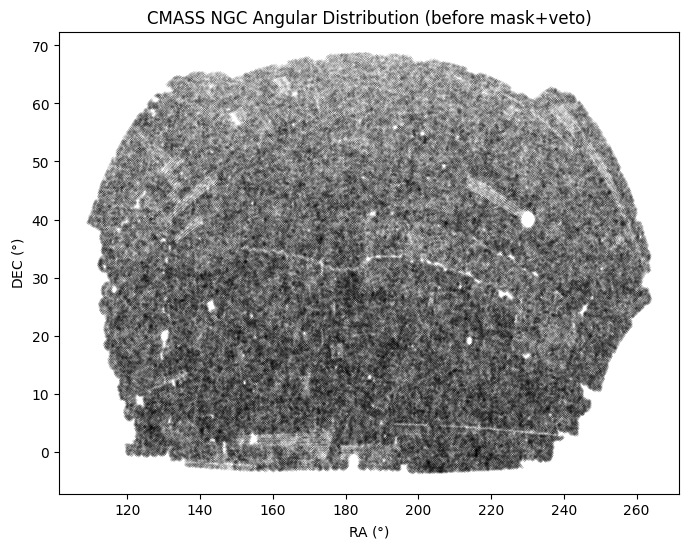

In [7]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(rdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('CMASS NGC Angular Distribution (before mask+veto)')

f.savefig('images/cmass_beforemask.jpg', dpi=400, bbox_inches='tight')

In [8]:
# cut on redshift
lrdz = len(rdz)
mask = BOSS_redshift(rdz[:,-1])
rdz = rdz[mask]

# angular cut
inpoly = BOSS_angular(*rdz[:,:-1].T)
inveto = BOSS_veto(*rdz[:,:-1].T)
mask = inpoly & (~inveto)
rdz = rdz[mask]

print('\n', lrdz, '->', len(rdz))

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply

 953255 -> 546782


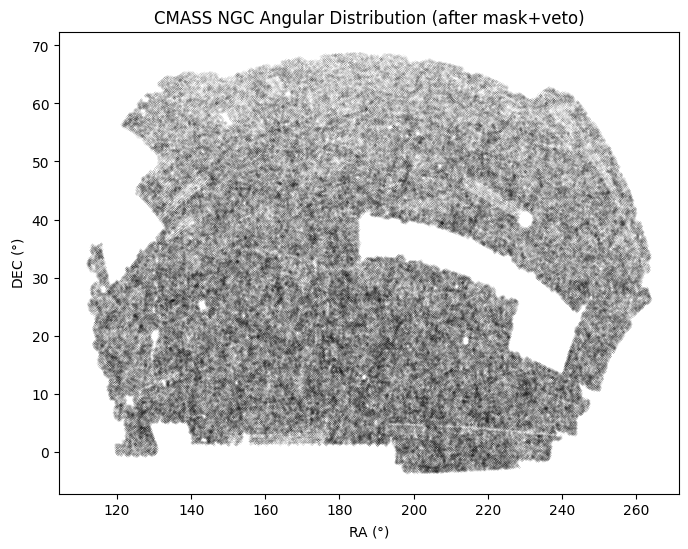

In [9]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(rdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('CMASS NGC Angular Distribution (after mask+veto)')

f.savefig('images/cmass_aftermask.jpg', dpi=400, bbox_inches='tight')

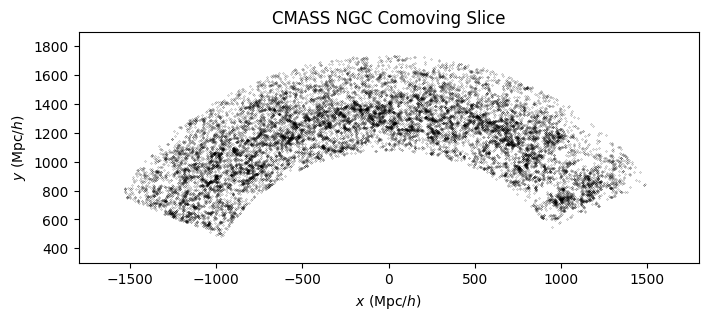

In [10]:
# plot comoving

DECcen = 5
mask = np.abs(rdz[:,1]-DECcen) < 1

pos = nblab.transform.SkyToCartesian(*rdz[mask,:].T, cosmo)
cxyzS = pos.compute()

f, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(cxyzS[:,1], -cxyzS[:,0], 'k.', alpha=1, markersize=0.3)
ax.set_xlim(-1800,1800)
ax.set_ylim(300,1900)
ax.set_xlabel(r'$x\ (\mathrm{Mpc}/h)$')
ax.set_ylabel(r'$y\ (\mathrm{Mpc}/h)$')
ax.set_title('CMASS NGC Comoving Slice')

f.savefig('images/cmass_comoving.jpg', dpi=400, bbox_inches='tight')

Text(0, 0.5, 'Count')

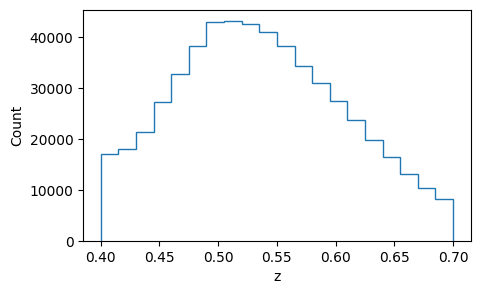

In [11]:
# plot n(z)

f, ax = plt.subplots(figsize=(5,3))
ax.hist(rdz[...,-1], 20, histtype='step')
ax.set_xlabel('z')
ax.set_ylabel('Count')

In [24]:
# calculate comoving positions of all galaxies
pos = nblab.transform.SkyToCartesian(*rdz.T, cosmo)
cxyz = pos.compute()

# Simulate from PM

In [12]:
# best-fit hod parameters
theta_hod = thetahod_literature('reid2014_cmass')

In [13]:
# load HOD halos
from nbodykit.source.catalog import BigFileCatalog
f = BigFileCatalog('data/fofT20B2_1.0000/LL-0.200', header='attr-v2')

print(f)
print("columns = ", f.columns) # default Weight,Selection also present
print("total size = ", f.csize)

BigFileCatalog(size=58252281, FileStack(BigFile(path=/home/mattho/git/cmass-ili/data/fofT20B2_1.0000/LL-0.200, dataset=./, ncolumns=10, shape=(58252281,)>, ... 1 files))
columns =  ['ID', 'InitialPosition', 'Length', 'MinID', 'Position', 'RVdisp', 'Rdisp', 'Selection', 'Task', 'Value', 'Vdisp', 'Velocity', 'Weight']
total size =  58252281


/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [14]:
# clean sample
mask = (f['Position']>0) & (f['Position']<3000) # idk why there are halos out here
mask = mask.all(axis=-1)
f = f[mask]

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


In [15]:
# calculate masses from particle counts
mp = float(f.attrs['M0'] * 1e10)
Ms = mp*f['Length']
f['Mass'] = Ms
f.attrs['BoxSize'] = (3000,3000,3000)

In [19]:
# populate with HOD
from nbodykit.hod import Zheng07Model, HODModel

halos = nblab.HaloCatalog(
            f, 
            cosmo=cosmo, 
            redshift=0, 
            mdef='vir') # not fof?
hod = halos.populate(Zheng07Model, seed=None, **theta_hod)

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/halotools/sim_manager/halo_table_cache.py:12: UserWarning: Some of the functionality of the HaloTableCache classrequires h5py to be installed.
  warn("Some of the functionality of the HaloTableCache class"
/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/halotools/sim_manager/halo_table_cache_log_entry.py:14: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda. 
  warn("Most of the functionality of the "
/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/halotools/sim_manager/user_supplied_ptcl_catalog.py:13: UserWarning: Most of the functionality of the sim_manager sub-package requires h5py to be installed,
which can be accomplished either with pip or conda
  warn("Most of the functionality of the sim_manager "
/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-pac

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


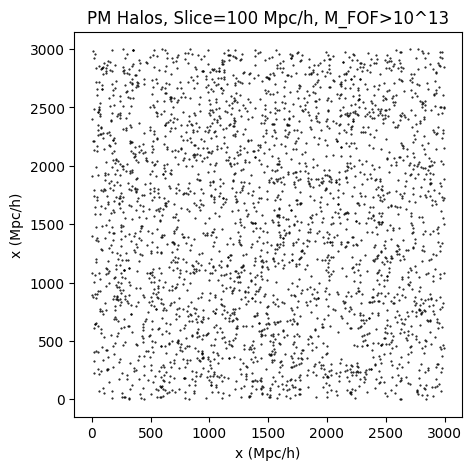

In [20]:
# plot PM Halos
mask = np.random.rand(len(f))<0.01
mask = mask & (f['Mass']>=10**(theta_hod['logMmin']))
pos = f['Position'][mask]

mask = pos[:,-1]<100
pos = pos[mask]
pos = np.array(pos)

fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(*(pos[:,:-1].T),'k.', alpha=1, markersize=1)
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('x (Mpc/h)')
ax.set_title('PM Halos, Slice=100 Mpc/h, M_FOF>10^13')
fig.savefig('images/pm_comoving.jpg', bbox_inches='tight', dpi=400)

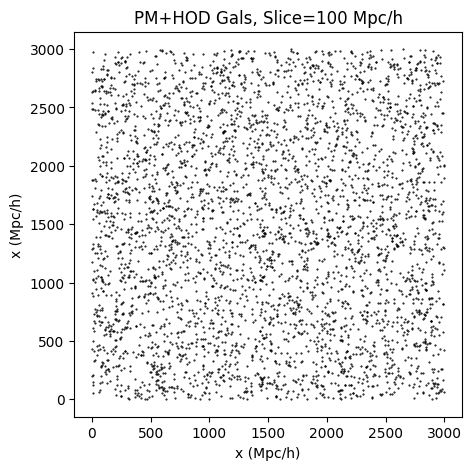

In [21]:
# plot PM+HOD
mask = np.random.rand(len(hod))<0.01
pos = hod['Position'][mask]

mask = pos[:,-1]<100
pos = pos[mask]
pos = np.array(pos)

fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(*(pos[:,:-1].T),'k.', alpha=1, markersize=1)
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('x (Mpc/h)')
ax.set_title('PM+HOD Gals, Slice=100 Mpc/h')
fig.savefig('images/pmhod_comoving.jpg', bbox_inches='tight', dpi=400)

## Rehape to Cuboid
This is super super slow to run (takes 10+ hours). So, for testing, I usually skip this and just multiply the positions by 1.04 to reach the necessary volume (next subsection).

TODO: make the Cuboid code faster

In [25]:
# calculate necessary simulation volume
lims = []
for t in cxyz.T:
    lims.append((t.min(), t.max()))

# figure out necessary cuboid reshaping parameters. from http://mwhite.berkeley.edu/BoxRemap/#code
m, n = 1, 0
L = 3000
lx = np.sqrt(1+m**2+n**2)
lz = 1/np.sqrt(1+n**2)
ly = (lx*lz)**-1

print('to fit:', np.diff(lims, axis=1)[:,0]/3000)
print('values:', lx,ly,lz)

to fit: [0.54378945 1.03972828 0.57178396]
values: 1.4142135623730951 0.7071067811865475 1.0


In [93]:
C = Cuboid(u1=(1,1,0), u2=(0,0,1), u3=(1,0,0))

In [ ]:
mask = np.random.rand(len(hod))<0.0001
xyz = hod['Position'][mask] / 3000.
pxyz = np.empty(xyz.shape)

for i in tqdm(range(len(xyz))):
    pxyz[i,:] = C.Transform(xyz[i,0], xyz[i,1], xyz[i,2]) # transformed

## Just multiply positions to make a larger volume

In [28]:
pxyz = hod['Position']
pvxyz = hod['Velocity']

pxyz *= 1.04 # bad bad bad

## Apply forward model

In [29]:
pxyz -= pxyz.min(axis=0)
pxyz += cxyz.min(axis=0)

pos = nblab.transform.CartesianToSky(pxyz, cosmo, pvxyz)
prdz = pos.compute().T

In [30]:
# cut on redshift
lrdz = len(prdz)
mask = BOSS_redshift(prdz[:,-1])
prdz = prdz[mask]

# angular cut
inpoly = BOSS_angular(*prdz[:,:-1].T)
inveto = BOSS_veto(*prdz[:,:-1].T)
mask = inpoly & (~inveto)
prdz = prdz[mask]

print('\n', lrdz, '->', len(prdz))

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply

 12317346 -> 1002203


Text(0, 0.5, 'Counts')

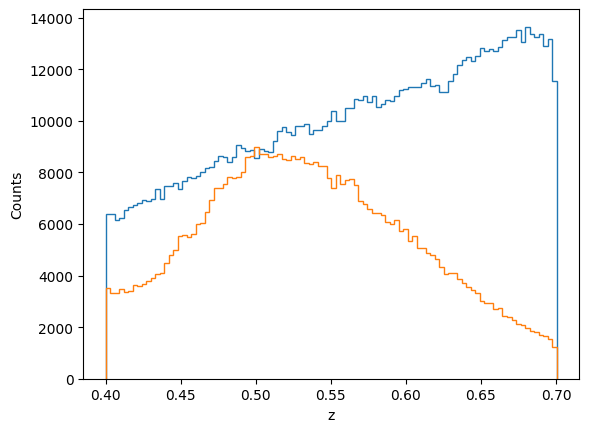

In [31]:
# calculate n(z) distribution
_, be = scott_bin_width(rdz[:,-1], True)
pcounts, _, _ = plt.hist(prdz[:,-1], be, histtype='step', label='PM')
counts, _, _ = plt.hist(rdz[:,-1], be, histtype='step', label='CMASS')
plt.xlabel('z')
plt.ylabel('Counts')

In [32]:
# resample PM to match CMASS
psamp = counts/pcounts
bind = np.digitize(prdz[:,-1], be)
mask = np.random.rand(len(prdz)) < psamp[bind-1]
prdz = prdz[mask]

Text(0, 0.5, 'Counts')

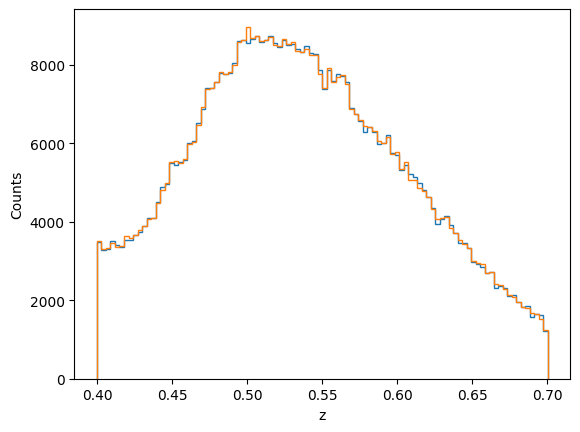

In [33]:
# plot to see the change
_ = plt.hist(prdz[:,-1], be, histtype='step')
_ = plt.hist(rdz[:,-1], be, histtype='step')
plt.xlabel('z')
plt.ylabel('Counts')

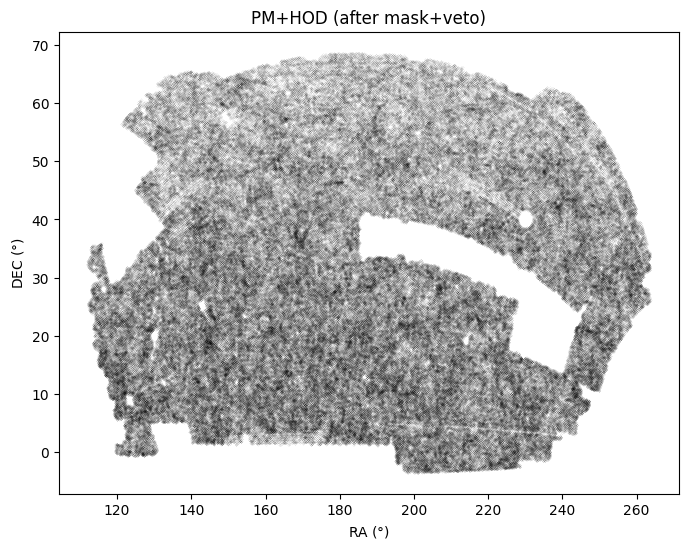

In [34]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(prdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('PM+HOD (after mask+veto)')

f.savefig('images/mock_aftermask.jpg', dpi=400, bbox_inches='tight')

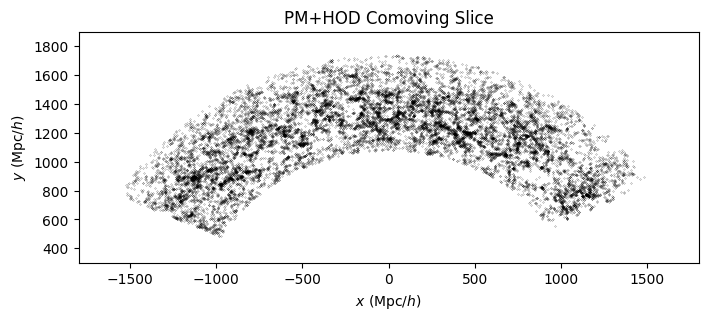

In [35]:
# plot comoving
DECcen = 5
mask = np.abs(prdz[:,1]-DECcen) < 1

pos = nblab.transform.SkyToCartesian(*prdz[mask,:].T, cosmo)
pxyzS = pos.compute()

f, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(pxyzS[:,1], -pxyzS[:,0], 'k.', alpha=1, markersize=0.3)
ax.set_xlim(-1800,1800)
ax.set_ylim(300,1900)
ax.set_xlabel(r'$x\ (\mathrm{Mpc}/h)$')
ax.set_ylabel(r'$y\ (\mathrm{Mpc}/h)$')
ax.set_title('PM+HOD Comoving Slice')

f.savefig('images/mock_comoving.jpg', dpi=400, bbox_inches='tight')

# Calculate power spectra

nbodykit: https://nbodykit.readthedocs.io/en/latest/cookbook/boss-dr12-data.html

simbig: https://github.com/changhoonhahn/simbig/blob/52e381d4fb82417dc9dbac0188b6d520deffc429/src/simbig/obs.py#L17
https://github.com/changhoonhahn/simbig/blob/52e381d4fb82417dc9dbac0188b6d520deffc429/cmass/nb/plk_0_observed_plk.ipynb

In [36]:
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals

In [37]:
# load data
fname = 'data/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)

In [38]:
# apply selection and calculate area
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

def BOSS_area():
    f_poly = os.path.join('data', 'mask_DR12v5_CMASSLOWZ_North.ply')
    boss_poly = pymangle.Mangle(f_poly) 
    area = np.sum(boss_poly.areas * boss_poly.weights) # deg^2
    return area
    
fsky = BOSS_area() / (360.**2 / np.pi)
fsky

0.15387008117114009009

In [39]:
# calculate weights
w_g = np.array(cmass['WEIGHT_SYSTOT'] * (cmass['WEIGHT_NOZ'] + cmass['WEIGHT_CP'] - 1.0))

In [40]:
# load randoms and apply selection
def load_randoms(gals, weights):
    fname = 'data/random0_DR12v5_CMASSLOWZTOT_North.fits'
    fields = ['RA','DEC','Z']
    randoms = load_galaxies(fname, fields)
    
    w, bins = scott_bin_width(np.array(gals['Z']), return_bins=True)
    hist, edges = np.histogram(np.array(gals['Z']), bins=bins, weights=weights) 
    cutoffs = np.cumsum(hist) / np.sum(hist)

    prng = np.random.uniform(size=len(randoms))
    randoms['Z'] = edges[:-1][cutoffs.searchsorted(prng)] + w * np.random.uniform(size=len(randoms))

    # further selection functions
    mask = BOSS_angular(randoms['RA'], randoms['DEC'])
    mask *= BOSS_redshift(randoms['Z'])
    randoms = randoms[mask]
    
    return randoms

randoms = load_randoms(cmass, w_g)

In [41]:
def get_nofz(z, fsky, cosmo=None): 
    ''' calculate nbar(z) given redshift values and f_sky (sky coverage
    fraction)
    Parameters
    ----------
    z : array like
        array of redshift values 
    fsky : float 
        sky coverage fraction  
    cosmo : cosmology object 
        cosmology to calculate comoving volume of redshift bins 
    Returns
    -------
    number density at input redshifts: nbar(z) 
    Notes
    -----
    * based on nbdoykit implementation 
    '''
    # calculate nbar(z) for each galaxy 
    _, edges = scott_bin_width(z, return_bins=True)

    dig = np.searchsorted(edges, z, "right")
    N = np.bincount(dig, minlength=len(edges)+1)[1:-1]

    R_hi = cosmo.comoving_distance(edges[1:]) # Mpc/h
    R_lo = cosmo.comoving_distance(edges[:-1]) # Mpc/h

    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    nofz = InterpolatedUnivariateSpline(0.5*(edges[1:] + edges[:-1]), N/dV, ext='const')
    
    return nofz

## Pk of CMASS

In [42]:
# calculate Pk

galaxies=cmass
P0=1e4
Ngrid=360
dk=0.005
Nr = len(randoms)
w_r = np.ones(Nr)

# get nbar(z) for the galaxy and random samples
ng_of_z = get_nofz(np.array(galaxies['Z']), fsky, cosmo=cosmo)
nbar_g = ng_of_z(np.array(galaxies['Z']))
nbar_r = ng_of_z(np.array(randoms['Z']))

# calculate xyz positions
pos_g = nblab.transform.SkyToCartesian(
    np.array(galaxies['RA']), 
    np.array(galaxies['DEC']), 
    np.array(galaxies['Z']), 
    cosmo=cosmo)
pos_r = nblab.transform.SkyToCartesian( 
    np.array(randoms['RA']), 
    np.array(randoms['DEC']), 
    np.array(randoms['Z']),
    cosmo=cosmo) 

_gals = nblab.ArrayCatalog({
    'Position': pos_g, 
    'NZ': nbar_g, 
    'WEIGHT': w_g, # np.ones(len(prdz)), # 
    'WEIGHT_FKP': 1./(1. + nbar_g * P0)
})

_rands = nblab.ArrayCatalog({ 
    'Position': pos_r, 
    'NZ': nbar_r,
    'WEIGHT': w_r,
    'WEIGHT_FKP': 1./(1. + nbar_r * P0)
})

fkp = nblab.FKPCatalog(_gals, _rands)
mesh = fkp.to_mesh(Nmesh=Ngrid, nbar='NZ', fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', window='tsc')

# compute the multipoles
r = nblab.ConvolvedFFTPower(mesh, poles=[0,2,4], dk=dk, kmin=0.)

k_gal = r.poles['k'] 
p0k_gal = r.poles['power_0'].real - r.attrs['shotnoise']
p2k_gal = r.poles['power_2'].real 
p4k_gal = r.poles['power_4'].real

/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


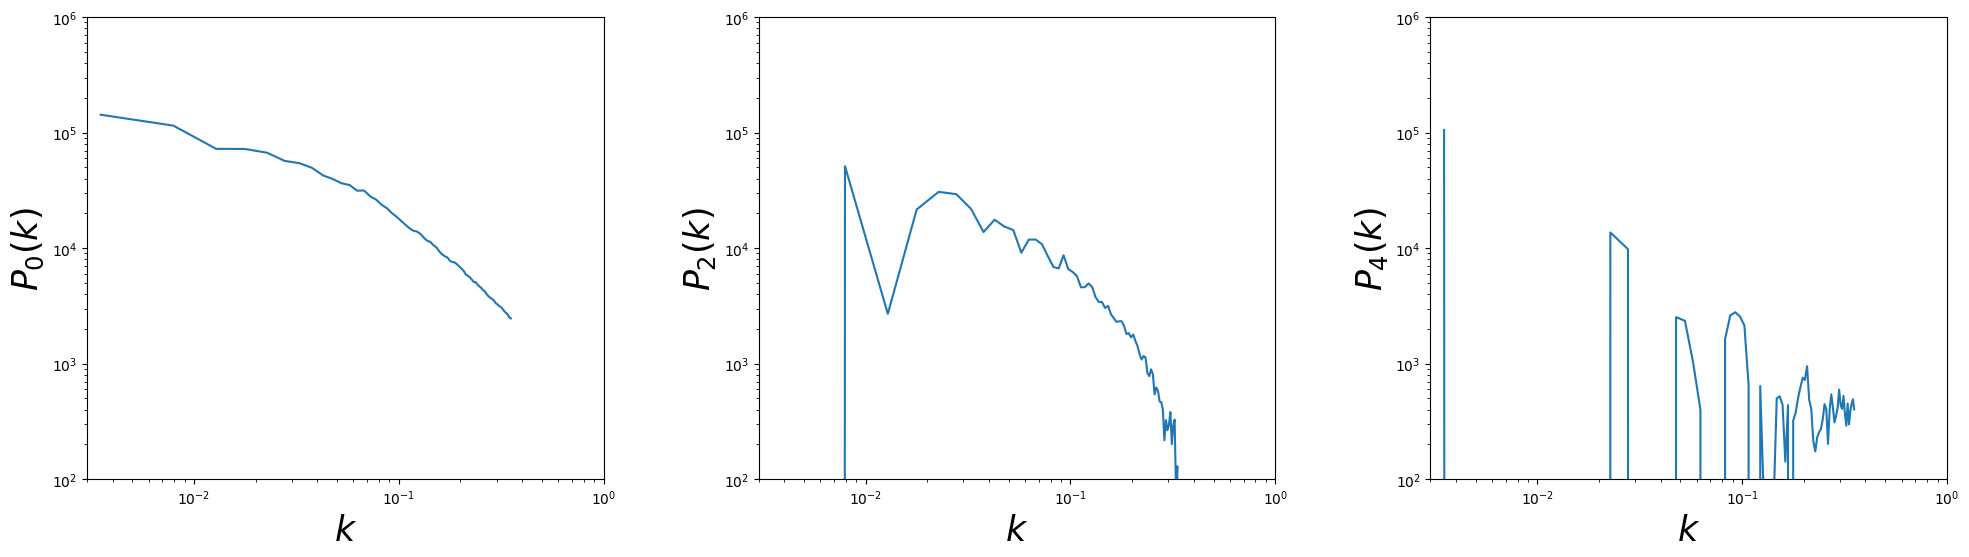

In [53]:
# plot

fig = plt.figure(figsize=(24,6))
for i, _plk in enumerate([p0k_gal, p2k_gal, p4k_gal]): 
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(k_gal, _plk)
    #sub.legend(loc='lower left', fontsize=10)
    sub.set_ylabel(r'$P_%i(k)$' % (i * 2), fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e2, 1e6)
    sub.set_xlabel('$k$', fontsize=25)
    sub.set_xlim([3e-3, 1.])
    sub.set_xscale('log')
    
fig.subplots_adjust(wspace=0.3)
# fig.savefig('images/cmass_ngc_Pk.jpg', bbox_inches='tight', dpi=400)

## Pk of PM mocks

In [ ]:
# calculate Pk

galaxies=cmass
P0=1e4
Ngrid=360
dk=0.005
Nr = len(randoms)
w_r = np.ones(Nr)

# get nbar(z) for the galaxy and random samples
ng_of_z = get_nofz(prdz[:,-1], fsky, cosmo=cosmo)
nbar_g = ng_of_z(prdz[:,-1])
nbar_r = ng_of_z(np.array(randoms['Z']))

# calculate xyz positions
pos_g = nblab.transform.SkyToCartesian(
    *prdz.T,
    cosmo=cosmo) 
pos_r = nblab.transform.SkyToCartesian( 
    np.array(randoms['RA']), 
    np.array(randoms['DEC']), 
    np.array(randoms['Z']),
    cosmo=cosmo) 

_gals = nblab.ArrayCatalog({
    'Position': pos_g, 
    'NZ': nbar_g, 
    'WEIGHT': np.ones(len(prdz)), # w_g, 
    'WEIGHT_FKP': 1./(1. + nbar_g * P0)
})

_rands = nblab.ArrayCatalog({ 
    'Position': pos_r, 
    'NZ': nbar_r,
    'WEIGHT': w_r,
    'WEIGHT_FKP': 1./(1. + nbar_r * P0)
})

fkp = nblab.FKPCatalog(_gals, _rands)
mesh = fkp.to_mesh(Nmesh=Ngrid, nbar='NZ', fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', window='tsc')

# compute the multipoles
r = nblab.ConvolvedFFTPower(mesh, poles=[0,2,4], dk=dk, kmin=0.)

k = r.poles['k'] 
p0k = r.poles['power_0'].real - r.attrs['shotnoise']
p2k = r.poles['power_2'].real 
p4k = r.poles['power_4'].real

In [ ]:
# plot

fig = plt.figure(figsize=(24,6))
for i, _plk in enumerate([p0k, p2k, p4k]): 
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(k, _plk)
    #sub.legend(loc='lower left', fontsize=10)
    sub.set_ylabel(r'$P_%i(k)$' % (i * 2), fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e2, 1e6)
    sub.set_xlabel('$k$', fontsize=25)
    sub.set_xlim([3e-3, 1.])
    sub.set_xscale('log')
    
fig.subplots_adjust(wspace=0.3)

## Plot both

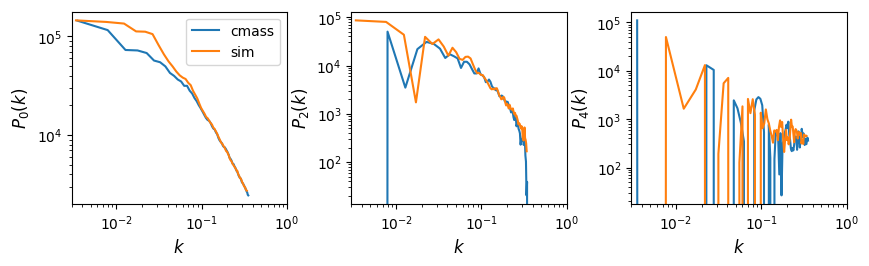

In [50]:
# plot

fig = plt.figure(figsize=(10,2.5))
for i, _plk in enumerate([(p0k, p0k_gal), (p2k, p2k_gal), (p4k, p4k_gal)]): 
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(k, _plk[1], label='cmass')
    sub.plot(k/1.04, _plk[0], label='sim')
    #sub.legend(loc='lower left', fontsize=10)
    sub.set_ylabel(r'$P_%i(k)$' % (i * 2), fontsize=12)
    sub.set_yscale('log')
    # sub.set_ylim(1e2, 1e6)
    sub.set_xlabel('$k$', fontsize=12)
    sub.set_xlim([3e-3, 1.])
    sub.set_xscale('log')
    
    if i==0:
        sub.legend()
    
fig.subplots_adjust(wspace=0.3)
# fig.savefig('images/cmass_compare_Pk.jpg', bbox_inches='tight', dpi=400)

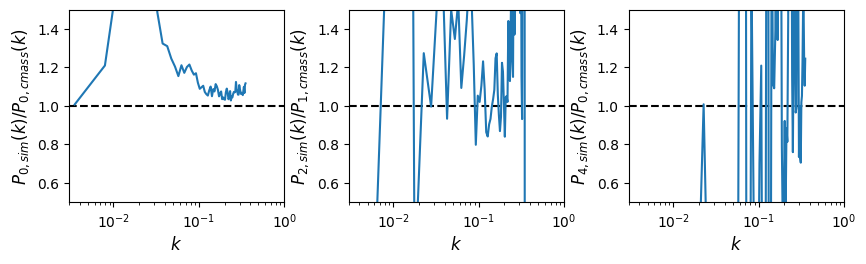

In [59]:
# plot

fig = plt.figure(figsize=(10,2.5))
for i, _plk in enumerate([(p0k, p0k_gal), (p2k, p2k_gal), (p4k, p4k_gal)]): 
    sub = fig.add_subplot(1,3,i+1)
    sub.axhline(1, color='k', linestyle='--')
    sub.plot(k, _plk[0]/_plk[1], label='cmass')
    #sub.legend(loc='lower left', fontsize=10)
    sub.set_ylabel(r'$P_{%i,sim}(k)/P_{%i,cmass}(k)$' % (i * 2, i%2), fontsize=12)
    # sub.set_yscale('log')
    sub.set_ylim(0.5, 1.5)
    sub.set_xlabel('$k$', fontsize=12)
    sub.set_xlim([3e-3, 1.])
    sub.set_xscale('log')
    
fig.subplots_adjust(wspace=0.3)
# fig.savefig('images/cmass_compare_Pk.jpg', bbox_inches='tight', dpi=400)

# Scratch

In [40]:
fname = '/home/mattho/data/cmass-ili/borg/cmass/density_L3000N750_quijLHfid.npy'
tmp = np.load(fname)

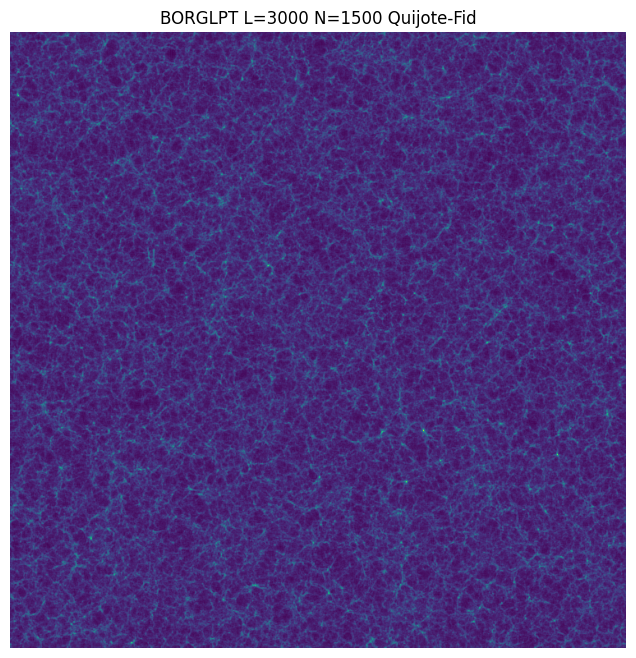

In [49]:
f, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.mean(tmp.T[0:15], axis=0))
ax.set_title('BORGLPT L=3000 N=1500 Quijote-Fid')
ax.axis('off')

f.savefig('images/borglpt_density.jpg')

## Old (ignore)

### Uniform Mock

In [19]:
# calculate comoving
pos = nblab.transform.SkyToCartesian(*rdz.T, cosmo)
cxyz = pos.compute()

In [42]:
# calculate average galaxy number density in survey
cmask = (cxyz[:,1]>-500) & (cxyz[:,1]<500)
cmask *= (-cxyz[:,0]>1200) & (-cxyz[:,0]<1400)
cmask *= (cxyz[:,2]>100) & (cxyz[:,2]<140)
nbar = np.sum(cmask)/(1000*200*40) # gals/(Mpc/h)^3

# calculate comoving survey limits
lims = []
for t in cxyz.T:
    lims.append((t.min(), t.max()))

vol = 1
for l in lims:
    vol *= np.diff(l)
N = int(vol[0]*nbar)

In [43]:
# uniformly sample in the survey volume with the correct number density
mxyz = np.zeros((N,3))
for i in range(3):
    mxyz[:,i] = np.random.uniform(*lims[i], size=N)
    
pos = nblab.transform.CartesianToSky(mxyz, cosmo)
mrdz = pos.compute().T

In [44]:
# cut on redshift
lrdz = len(mrdz)
mask = BOSS_redshift(mrdz[:,-1])
mrdz = mrdz[mask]

# angular cut
inpoly = BOSS_angular(*mrdz[:,:-1].T)
inveto = BOSS_veto(*mrdz[:,:-1].T)
mask = inpoly & (~inveto)
mrdz = mrdz[mask]

print('\n', lrdz, '->', len(mrdz))

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply

 3158675 -> 891722


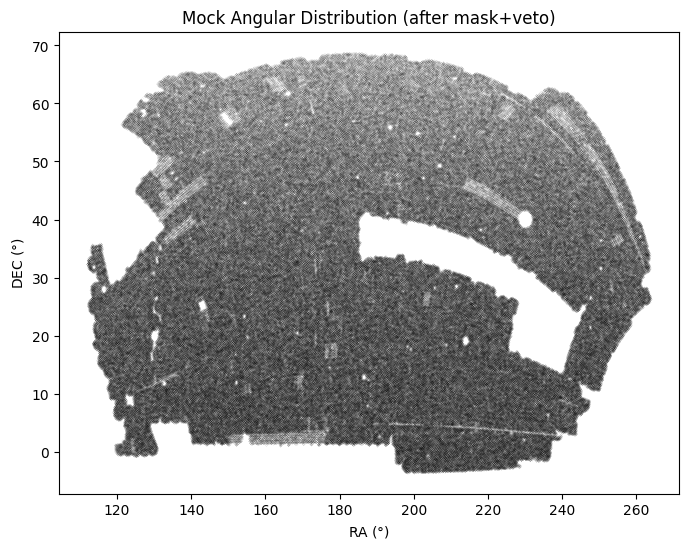

In [45]:
f,ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(*(mrdz[:,:-1].T),'k.', alpha=1, markersize=0.05)
ax.set_xlabel(r'RA $(\degree)$')
ax.set_ylabel(r'DEC $(\degree)$')
ax.set_title('Mock Angular Distribution (after mask+veto)')

f.savefig('images/mock_aftermask.jpg', dpi=400, bbox_inches='tight')

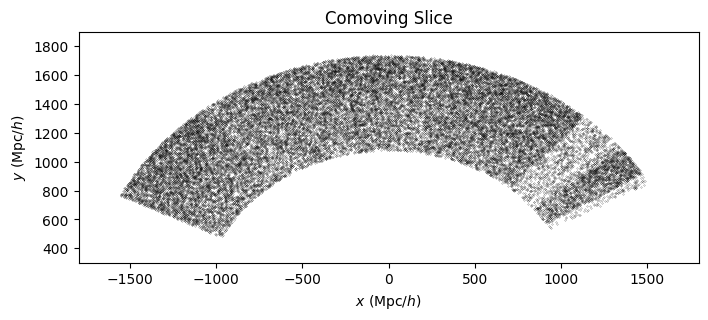

In [46]:
# plot comoving
DECcen = 5
mask = np.abs(mrdz[:,1]-DECcen) < 1

pos = nblab.transform.SkyToCartesian(*mrdz[mask,:].T, cosmo)
mxyzS = pos.compute()

f, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(mxyzS[:,1], -mxyzS[:,0], 'k.', alpha=1, markersize=0.3)
ax.set_xlim(-1800,1800)
ax.set_ylim(300,1900)
ax.set_xlabel(r'$x\ (\mathrm{Mpc}/h)$')
ax.set_ylabel(r'$y\ (\mathrm{Mpc}/h)$')
ax.set_title('Comoving Slice')

f.savefig('images/mock_comoving.jpg', dpi=400, bbox_inches='tight')

### Real

In [111]:
xyz = hod['Position'] / 3000.

In [112]:
xyz

dask.array<truediv, shape=(12313241, 3), dtype=float32, chunksize=(100000, 1), chunktype=numpy.ndarray>

In [63]:
from tools.remap import Cuboid

[(-1737.9898001650342, -106.62145308282662),
 (-1603.6382546230545, 1515.5465789353923),
 (-106.69083499100688, 1608.661046733758)]

to fit: [0.54378945 1.03972828 0.57178396]
values: 1.4142135623730951 0.7071067811865475 1.0


In [107]:
np.max(xyz_t, axis=0)

array([1.41410385, 0.99970758, 0.70656208])